In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
SCORE_MEASURES = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'average_precision']
TIME_MEASURES = ['collecting_datasets', 'training', 'training_per_epoch', 'prediction']
MEASURES = SCORE_MEASURES + TIME_MEASURES

MEASURES_AGGREGATION = { m: ['mean', 'std'] for m in MEASURES }

MEASURE_NAMES = { m: m.capitalize().replace('_', ' ') for m in MEASURES }
for m in TIME_MEASURES:
    MEASURE_NAMES[m] += ' time [s]'

In [3]:
def aggregate_results(results, experiment_type):
    if not 'task' in results.columns:
        results['task'] = 1
    results_filtered = results[results['experiment_type'] == experiment_type]
    experiment_type = experiment_type.replace(' ', '_')
    return results_filtered.groupby([experiment_type, 'task']).agg(MEASURES_AGGREGATION)

In [4]:
# we decrease the number of plots in case of multilabel classification to make it more readable,

ICD9_TASKS = {
    1: (0.5807, 0.7643),
    2: (0.7422, 0.8467),
    3: (0.8377, 0.7203),
    4: (0.6556, 0.7575),
    5: (0.5058, 0.6680),
#     6: (0.4566, 0.6651),
#     7: (0.9592, 0.8435),
#     8: (0.7493, 0.7447),
#     9: (0.6393, 0.7023),
#     10: (0.7715, 0.8089),
#     11: (0.1498, 0.8200),
#     12: (0.1930, 0.6670),
#     13: (0.2641, 0.6185),
#     14: (0.1134, 0.7003),
#     15: (0.4848, 0.6583),
#     16: (0.1488, 0.6243),
#     17: (0.0742, 0.6976),
#     18: (0.6430, 0.6722),
#     19: (0.6684, 0.6931),
#     20: (0.5506, 0.6719),
}
ICD9_TASKS = {k: {"average_precision": v[0], "roc_auc": v[1]} for k, v in ICD9_TASKS.items()}

MORTALITY_TASKS = {1: {"average_precision": 0.4632, "roc_auc": 0.8496}}

In [5]:
def task_color(task):
    return plt.cm.tab20(task * 2 % 20)

def plot(grouped_results, xlabel, reference_results):
    fig, axes = plt.subplots(nrows=len(MEASURES) // 2, ncols=2, figsize=(15, 3.5 * len(MEASURES)))
    for i, measure in enumerate(MEASURES):
        ax = axes[i // 2][i % 2]
        time_plot_done = False
        for task, task_data in reference_results.items():
            # only one plot for time data
            if measure in TIME_MEASURES and time_plot_done:
                continue
            df = grouped_results.xs(task, level=1)
            if measure in task_data:
                ax.axhline(task_data[measure], linestyle='--', c=task_color(task))
            ax.errorbar(
                df.index,
                df[measure]['mean'], df[measure]['std'],
                linestyle='None', marker='x', uplims=True, lolims=True,
                c=task_color(task),
            )
            if measure in TIME_MEASURES:
                time_plot_done = True
        ax.set_xscale('log')
        xticks = grouped_results.index.get_level_values(0).unique().sort_values()
        ax.set_xticks(xticks)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.set_xlabel(xlabel, size=14)
        ax.set_ylabel(MEASURE_NAMES[measure], size=14)
        ax.set_title(f'{xlabel} vs. {MEASURE_NAMES[measure]}', size=17)
        ax.grid(True)
    plt.show()

### Mortality

In [6]:
mortality_results = pd.read_csv('results/mortality_binary_classification.csv')

In [7]:
mortality_results

,experiment_type,train_size,num_of_workers,accuracy,precision,recall,f1_score,roc_auc,average_precision,collecting_datasets,training,training_per_epoch,prediction
0,train size,50.0,3,0.844557,0.263780,0.268717,0.266225,0.668863,0.235348,0.008256,6.395798,0.177661,6.864800
1,train size,50.0,3,0.867845,0.289130,0.177807,0.220199,0.649171,0.210330,0.008318,6.863202,0.159609,6.822238
2,train size,50.0,3,0.895062,0.000000,0.000000,0.000000,0.594525,0.175119,0.008331,3.356932,0.159854,6.879266
3,train size,50.0,3,0.853795,0.309677,0.321285,0.315375,0.695017,0.274136,0.008504,27.215147,0.159153,6.826596
4,train size,50.0,3,0.895173,0.000000,0.000000,0.000000,0.574698,0.175087,0.008432,3.384312,0.161158,6.814792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,num of workers,NaN,128,0.903479,0.631579,0.192513,0.295082,0.843949,0.447426,0.641160,885.850644,26.843959,9.765104
66,num of workers,NaN,128,0.903058,0.615385,0.203209,0.305528,0.838457,0.431690,0.637118,859.582958,26.861967,9.847033
67,num of workers,NaN,128,0.903339,0.590214,0.258021,0.359070,0.857980,0.468422,0.641292,1396.071816,26.847535,9.994235
68,num of workers,NaN,128,0.905711,0.677725,0.191432,0.298539,0.845900,0.455985,0.645691,939.973848,26.856396,9.286214


In [8]:
grouped_mortality_train_size = aggregate_results(mortality_results, 'train size')
grouped_mortality_train_size

accuracy           precision              recall            \
                     mean       std      mean       std      mean       std   
train_size task                                                               
50.0       1     0.871286  0.023281  0.172517  0.158323  0.153562  0.149283   
100.0      1     0.895783  0.001874  0.165730  0.254953  0.028112  0.061376   
500.0      1     0.894772  0.003535  0.506396  0.088421  0.073821  0.045158   
1000.0     1     0.895979  0.002078  0.578088  0.070067  0.081821  0.075944   
5000.0     1     0.902405  0.002120  0.597751  0.039922  0.220697  0.020021   
10000.0    1     0.903275  0.001992  0.628456  0.040408  0.194219  0.013686   

                 f1_score             roc_auc           average_precision  \
                     mean       std      mean       std              mean   
train_size task                                                             
50.0       1     0.160360  0.150207  0.636455  0.050531          0.214004   
100.0      1     0.045599  0.099031  0.692697  0.048257          0.254059   
500.0      1     0.124119  0.066880  0.704440  0.035047          0.260126   
1000.0     1     0.129694  0.114646  0.753855  0.012370          0.333922   
5000.0     1     0.321280  0.016919  0.821088  0.010922          0.422567   
10000.0    1     0.296169  0.014874  0.832807  0.005578          0.437308   

                          collecting_datasets              training  \
                      std                mean       std        mean   
train_size task                                                       
50.0       1     0.042165            0.008368  0.000099    9.443078   
100.0      1     0.055210            0.008320  0.000122    5.549138   
500.0      1     0.037059            0.008241  0.000061   16.153625   
1000.0     1     0.018334            0.008434  0.000242   43.988002   
5000.0     1     0.009970            0.008298  0.000062  274.131447   
10000.0    1     0.014329            0.008555  0.000277  588.138484   

                           training_per_epoch           prediction            
                       std               mean       std       mean       std  
train_size task                                                               
50.0       1     10.068986           0.163487  0.007958   6.841538  0.028617  
100.0      1      1.787458           0.180284  0.001332   6.863178  0.033307  
500.0      1      3.187924           0.438811  0.004274   6.708847  0.080304  
1000.0     1     20.233890           0.743658  0.002666   6.800266  0.045685  
5000.0     1     51.456880           3.540162  0.011825   6.817570  0.128595  
10000.0    1     88.225909           7.018888  0.018665   7.056671  0.192704

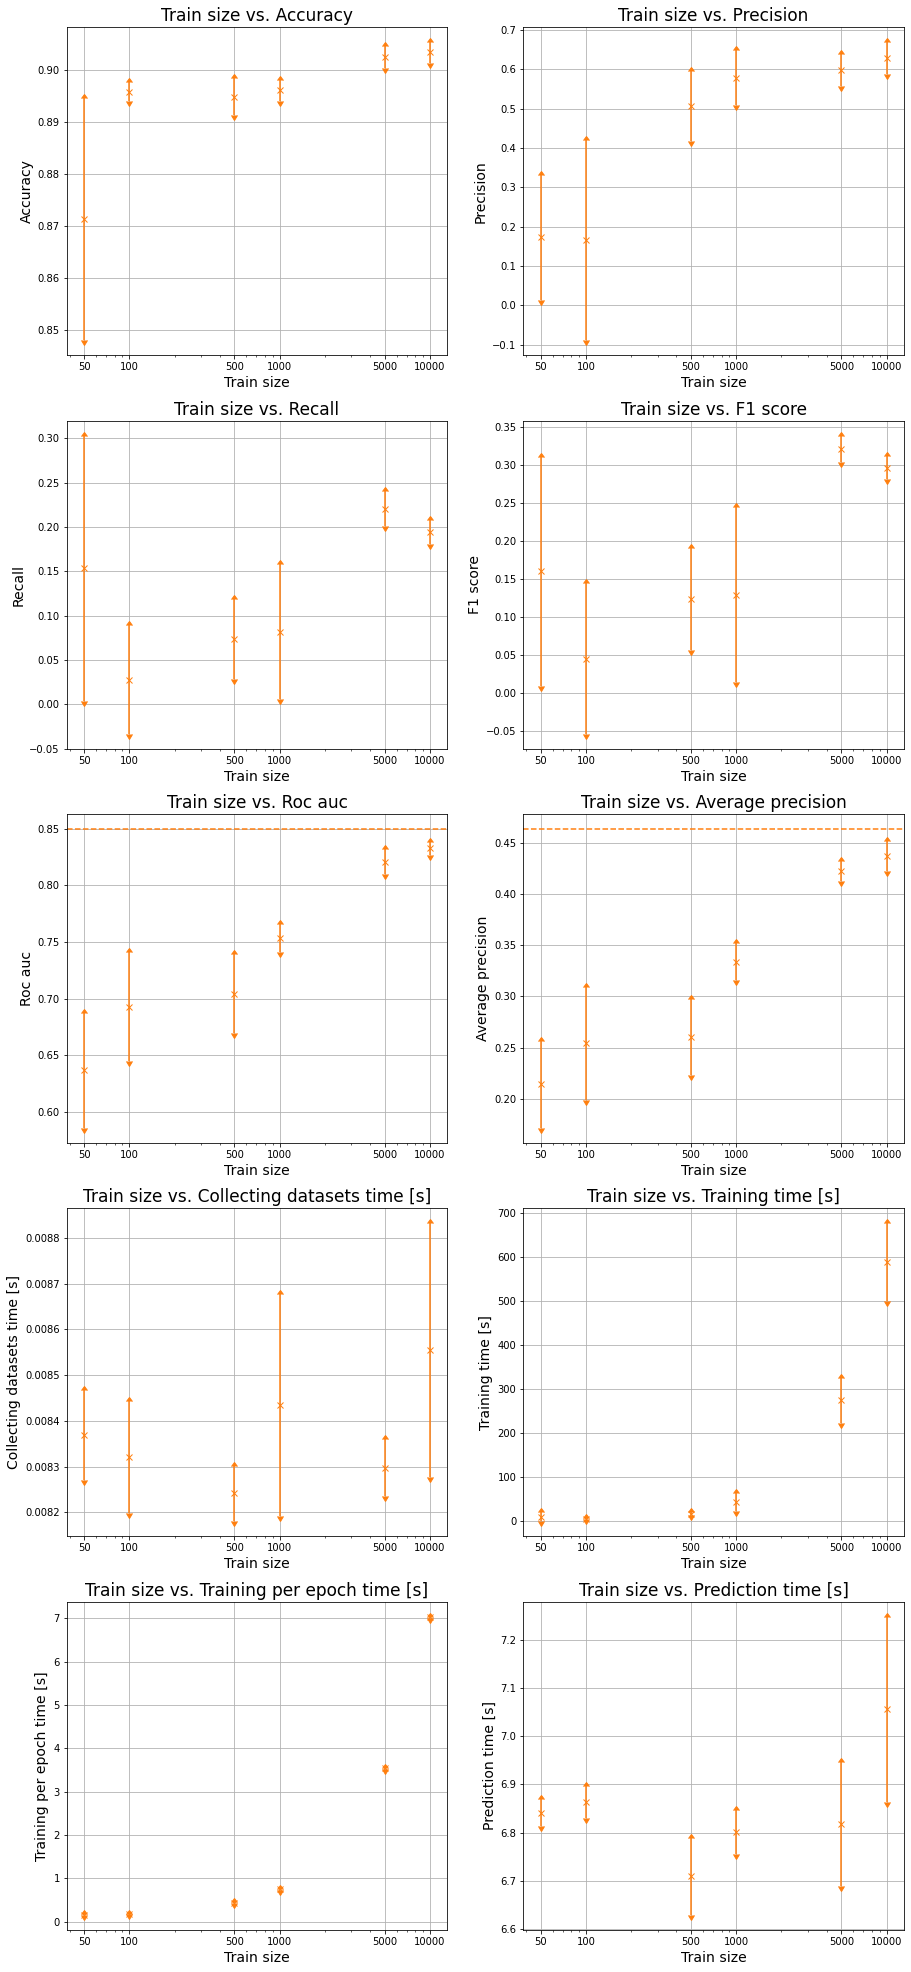

In [9]:
plot(grouped_mortality_train_size, 'Train size', MORTALITY_TASKS)

In [10]:
grouped_mortality_workers = aggregate_results(mortality_results, 'num of workers')
grouped_mortality_workers

accuracy           precision              recall  \
                         mean       std      mean       std      mean   
num_of_workers task                                                     
1              1     0.906446  0.001889  0.647370  0.031961  0.240236   
2              1     0.905688  0.001890  0.634346  0.035334  0.242907   
4              1     0.905492  0.001457  0.633800  0.034573  0.240228   
8              1     0.905548  0.001311  0.630685  0.021746  0.241572   
16             1     0.906193  0.001360  0.660289  0.036173  0.222840   
32             1     0.905379  0.001838  0.637231  0.038461  0.233007   
64             1     0.905688  0.001198  0.644877  0.016236  0.224986   
128            1     0.903948  0.001064  0.637023  0.036902  0.202770   

                               f1_score             roc_auc            \
                          std      mean       std      mean       std   
num_of_workers task                                                     
1              1     0.018067  0.349784  0.017164  0.852484  0.004878   
2              1     0.023048  0.350238  0.020039  0.853090  0.005667   
4              1     0.028817  0.346896  0.025267  0.853225  0.004927   
8              1     0.012254  0.349045  0.011783  0.852953  0.005222   
16             1     0.028878  0.331630  0.026894  0.852065  0.006033   
32             1     0.022153  0.340073  0.019236  0.851844  0.007152   
64             1     0.017640  0.333222  0.019245  0.845967  0.008716   
128            1     0.033351  0.305547  0.032869  0.847218  0.007275   

                    average_precision           collecting_datasets            \
                                 mean       std                mean       std   
num_of_workers task                                                             
1              1             0.469128  0.009324            0.003280  0.000154   
2              1             0.470601  0.012030            0.006051  0.000302   
4              1             0.468754  0.010782            0.011126  0.000286   
8              1             0.470044  0.009745            0.022801  0.000608   
16             1             0.468741  0.010376            0.046423  0.001825   
32             1             0.466997  0.012225            0.101691  0.000474   
64             1             0.459220  0.013869            0.245394  0.002262   
128            1             0.454057  0.015131            0.639437  0.005180   

                        training             training_per_epoch            \
                            mean         std               mean       std   
num_of_workers task                                                         
1              1     1423.962022  158.023648          19.992243  0.085316   
2              1     1456.008804  214.721726          20.267370  0.099509   
4              1     1431.775481  144.447996          20.389924  0.102932   
8              1     1383.396039  113.655671          20.470017  0.092388   
16             1     1184.169107  113.568254          20.917346  0.085293   
32             1     1063.760777  197.238724          21.615168  0.069703   
64             1     1117.065253  257.427357          24.486401  0.064618   
128            1     1020.978566  218.843973          26.868359  0.036246   

                    prediction            
                          mean       std  
num_of_workers task                       
1              1      7.381367  0.436188  
2              1      7.618592  0.154550  
4              1      7.322843  0.517240  
8              1      7.242310  0.554256  
16             1      7.094450  0.328773  
32             1      7.668904  0.453551  
64             1      8.900032  0.294952  
128            1      9.635018  0.330469

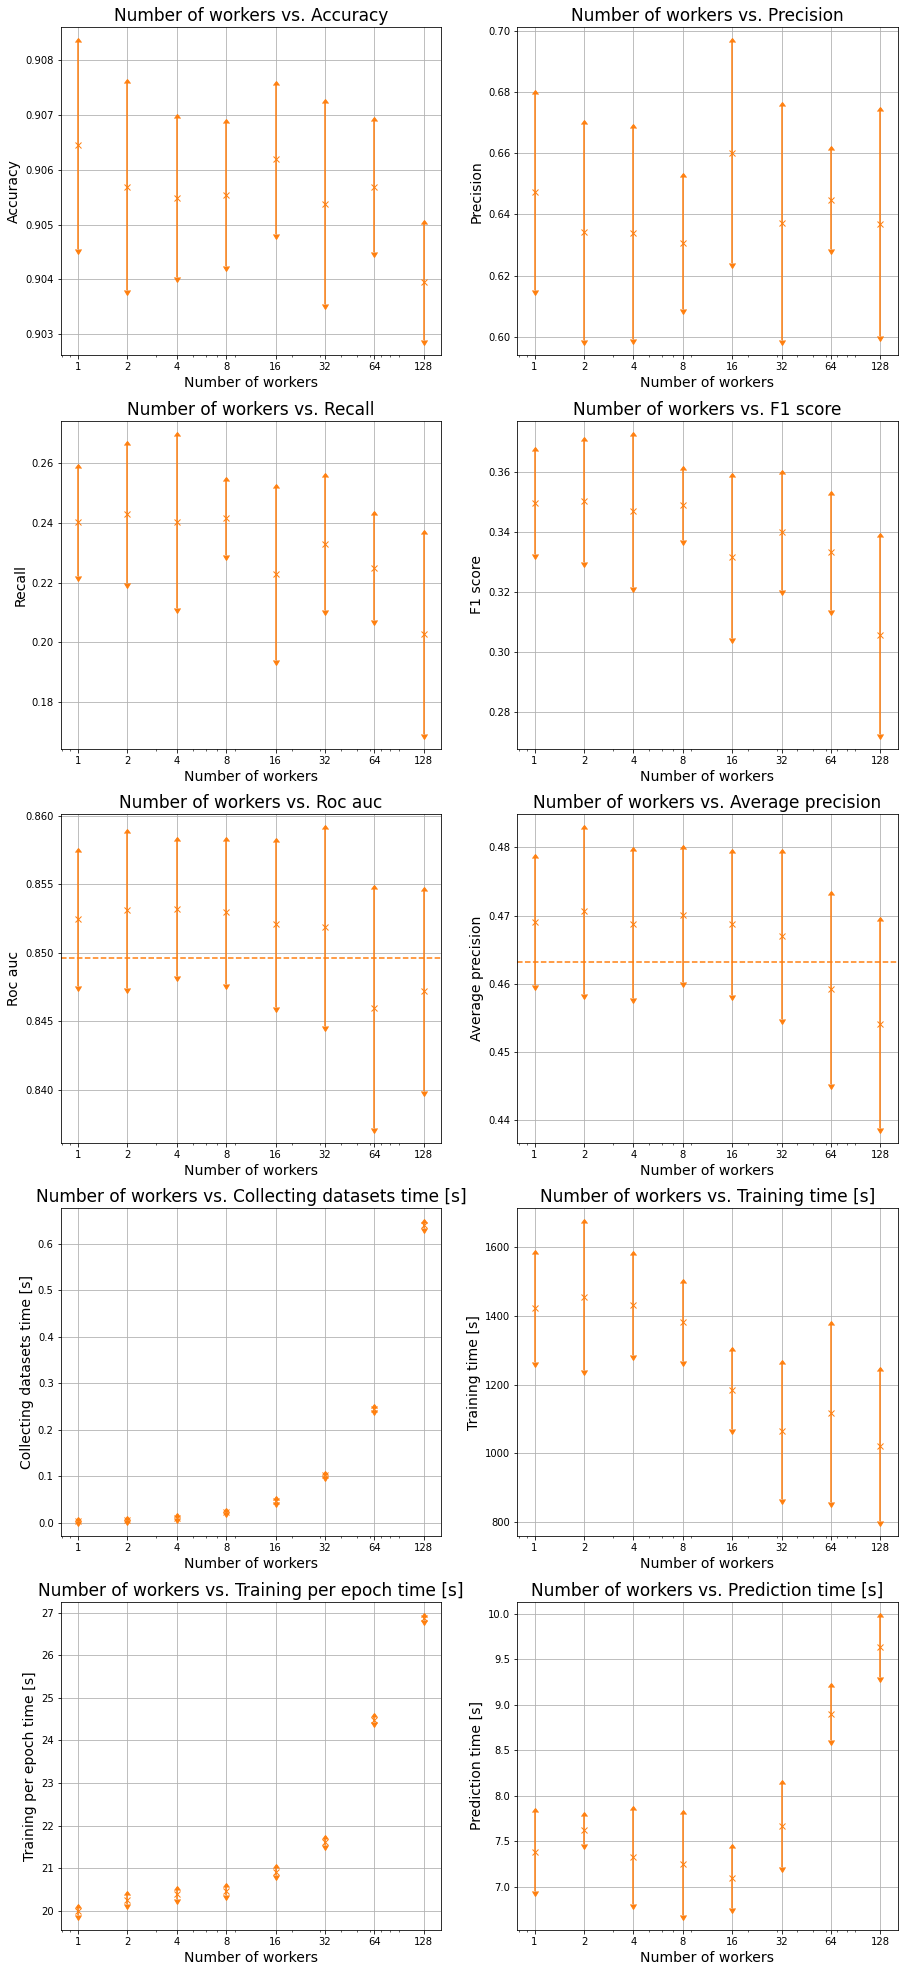

In [11]:
plot(grouped_mortality_workers, 'Number of workers', MORTALITY_TASKS)

### ICD-9

In [12]:
icd9_results = pd.read_csv('results/icd9_multilabel_classification.csv')

In [13]:
grouped_icd9_train_size = aggregate_results(icd9_results, 'train size')
grouped_icd9_train_size

accuracy           precision              recall            \
                     mean       std      mean       std      mean       std   
train_size task                                                               
50.0       1     0.739113  0.005734  0.195478  0.268322  0.051436  0.083334   
           2     0.823064  0.002300  0.133333  0.298142  0.004358  0.009745   
           3     0.670679  0.023036  0.712225  0.035749  0.891324  0.148301   
           4     0.632183  0.003691  0.238433  0.331399  0.068548  0.139056   
           5     0.657464  0.050455  0.243167  0.227761  0.075206  0.146525   
...                   ...       ...       ...       ...       ...       ...   
10000.0    16    0.916274  0.003511  0.000000  0.000000  0.000000  0.000000   
           17    0.969501  0.001351  0.000000  0.000000  0.000000  0.000000   
           18    0.627722  0.004828  0.610633  0.009142  0.461715  0.019711   
           19    0.599355  0.009441  0.586597  0.008322  0.575098  0.073242   
           20    0.692452  0.004805  0.609994  0.024603  0.189357  0.030107   

                 f1_score             roc_auc           average_precision  \
                     mean       std      mean       std              mean   
train_size task                                                             
50.0       1     0.077454  0.119300  0.594953  0.047503          0.350070   
           2     0.008440  0.018873  0.652642  0.035010          0.326816   
           3     0.784255  0.041165  0.582123  0.109218          0.742544   
           4     0.088563  0.171162  0.603740  0.033297          0.478775   
           5     0.080701  0.141959  0.502144  0.036587          0.329062   
...                   ...       ...       ...       ...               ...   
10000.0    16    0.000000  0.000000  0.584007  0.017235          0.111128   
           17    0.000000  0.000000  0.670496  0.027676          0.057700   
           18    0.525537  0.010730  0.658691  0.002841          0.621891   
           19    0.578700  0.036457  0.642423  0.006389          0.598218   
           20    0.287500  0.032744  0.635833  0.004836          0.496487   

                          collecting_datasets              training  \
                      std                mean       std        mean   
train_size task                                                       
50.0       1     0.038477            0.009909  0.000094     7.68924   
           2     0.065322            0.009909  0.000094     7.68924   
           3     0.075553            0.009909  0.000094     7.68924   
           4     0.029507            0.009909  0.000094     7.68924   
           5     0.026923            0.009909  0.000094     7.68924   
...                   ...                 ...       ...         ...   
10000.0    16    0.004730            0.010015  0.000339  1028.91498   
           17    0.009386            0.010015  0.000339  1028.91498   
           18    0.002511            0.010015  0.000339  1028.91498   
           19    0.005447            0.010015  0.000339  1028.91498   
           20    0.010517            0.010015  0.000339  1028.91498   

                           training_per_epoch           prediction            
                       std               mean       std       mean       std  
train_size task                                                               
50.0       1      1.741724           0.215593  0.016520   8.696535  0.021058  
           2      1.741724           0.215593  0.016520   8.696535  0.021058  
           3      1.741724           0.215593  0.016520   8.696535  0.021058  
           4      1.741724           0.215593  0.016520   8.696535  0.021058  
           5      1.741724           0.215593  0.016520   8.696535  0.021058  
...                    ...                ...       ...        ...       ...  
10000.0    16    96.600078           8.977784  0.024504   8.837266  0.318362  
           17    96.600078           8.977784 

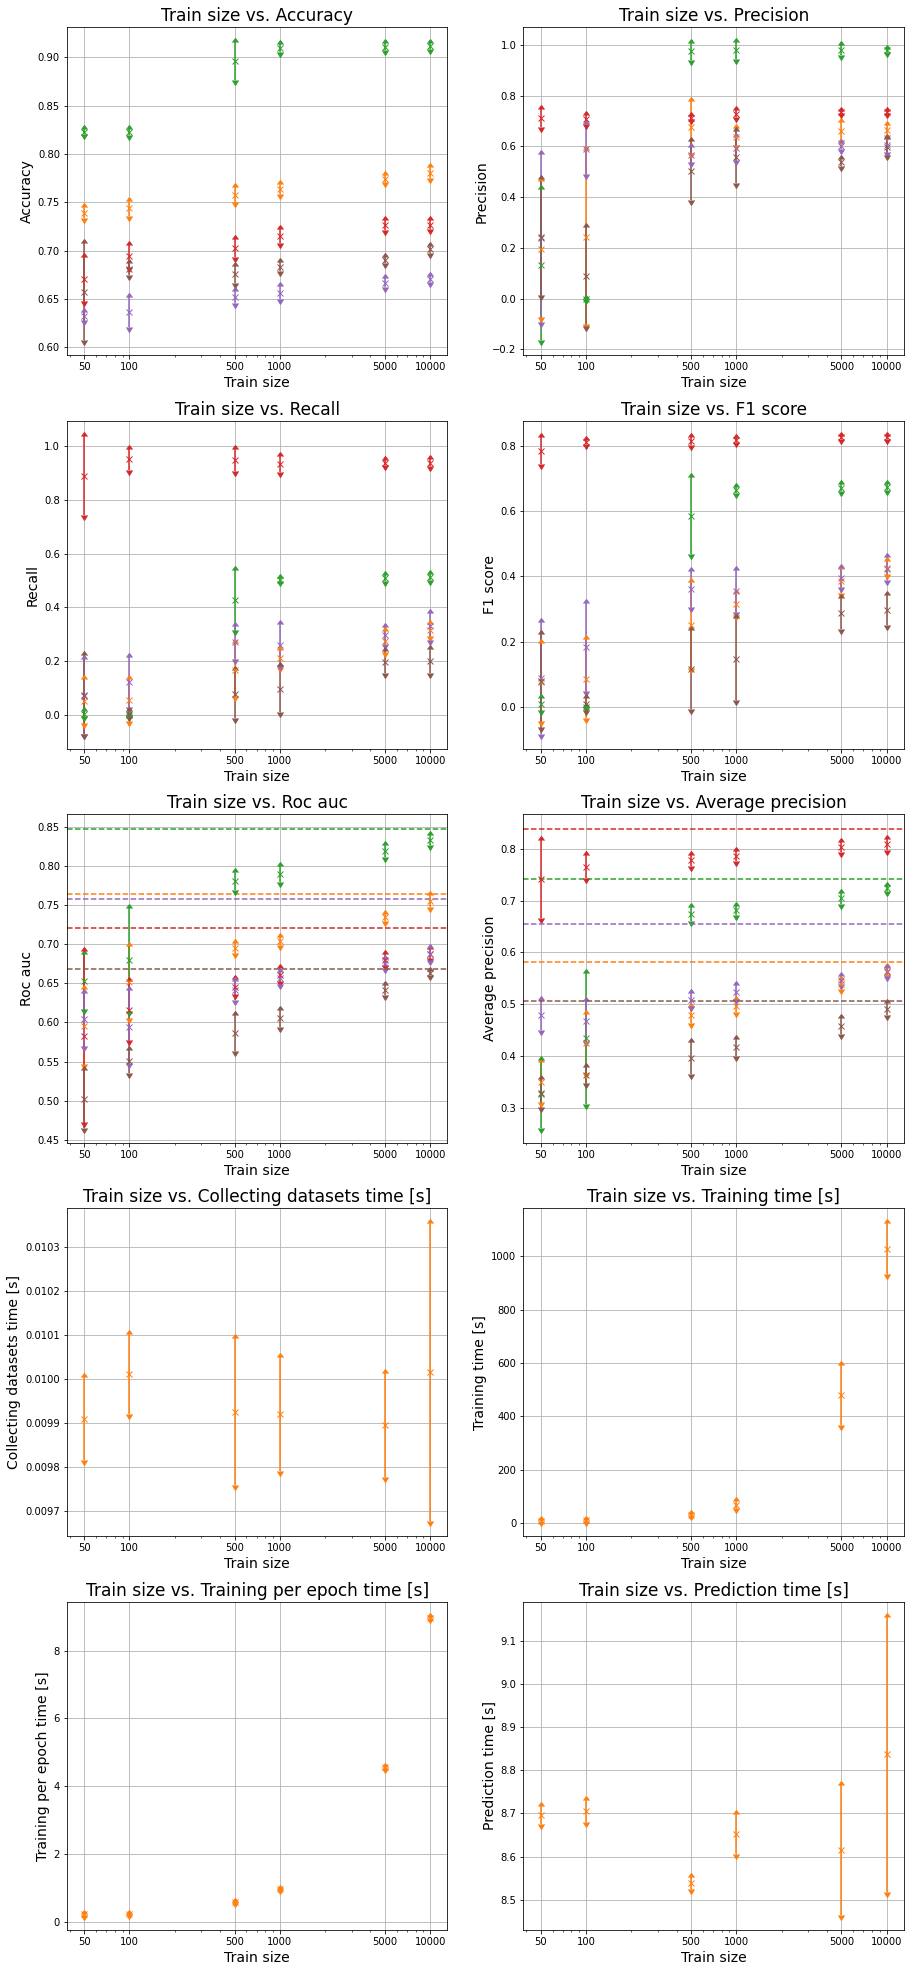

In [14]:
plot(grouped_icd9_train_size, 'Train size', ICD9_TASKS)

In [15]:
grouped_icd9_workers = aggregate_results(icd9_results, 'num of workers')
grouped_icd9_workers

accuracy           precision              recall  \
                         mean       std      mean       std      mean   
num_of_workers task                                                     
1              1     0.782716  0.003229  0.673821  0.020775  0.316575   
               2     0.912402  0.002994  0.980562  0.007307  0.516364   
               3     0.730219  0.005940  0.737129  0.006775  0.944028   
               4     0.675561  0.003550  0.606835  0.021233  0.357285   
               5     0.706734  0.005477  0.609300  0.016454  0.220983   
...                       ...       ...       ...       ...       ...   
128            16    0.916274  0.003511  0.000000  0.000000  0.000000   
               17    0.969501  0.001351  0.000000  0.000000  0.000000   
               18    0.634989  0.005582  0.637245  0.017600  0.428156   
               19    0.605892  0.006464  0.592096  0.007713  0.588593   
               20    0.700309  0.003835  0.676290  0.008302  0.173536   

                               f1_score             roc_auc            \
                          std      mean       std      mean       std   
num_of_workers task                                                     
1              1     0.014932  0.430343  0.010388  0.769826  0.006451   
               2     0.007863  0.676463  0.007516  0.849647  0.005091   
               3     0.008496  0.827812  0.004504  0.697838  0.005845   
               4     0.034842  0.448340  0.022034  0.701625  0.008450   
               5     0.018471  0.323974  0.020932  0.678409  0.003280   
...                       ...       ...       ...       ...       ...   
128            16    0.000000  0.000000  0.000000  0.572996  0.010720   
               17    0.000000  0.000000  0.000000  0.653543  0.010055   
               18    0.034556  0.511147  0.021071  0.670133  0.005063   
               19    0.034016  0.589850  0.015703  0.648798  0.007179   
               20    0.014058  0.275997  0.018248  0.649472  0.002550   

                    average_precision           collecting_datasets            \
                                 mean       std                mean       std   
num_of_workers task                                                             
1              1             0.582442  0.005869            0.004352  0.000120   
               2             0.745639  0.005851            0.004352  0.000120   
               3             0.817703  0.006294            0.004352  0.000120   
               4             0.579151  0.008435            0.004352  0.000120   
               5             0.512603  0.011868            0.004352  0.000120   
...                               ...       ...                 ...       ...   
128            16            0.105548  0.005876            0.882713  0.006113   
               17            0.054557  0.004227            0.882713  0.006113   
               18            0.634360  0.004588            0.882713  0.006113   
               19            0.602772  0.007299            0.882713  0.006113   
               20            0.513645  0.009039            0.882713  0.006113   

                        training             training_per_epoch            \
                            mean         std               mean       std   
num_of_workers task                                                         
1              1     2599.782615  112.062922          25.891197  0.220898   
               2     2599.782615  112.062922          25.891197  0.220898   
               3     2599.782615  112.062922          25.891197  0.220898   
               4     2599.782615  112.062922          25.891197  0.220898   
               5     2599.782615  112.062922          25.891197  0.220898   
...                          ...         ...                ...       ...   
128            16    1866.143338  310.056407          36.844556  0.362382   
               17    1866.143338  310.056407          36.844556  0.362

In [ ]:
plot(grouped_icd9_workers, 'Num of workers', ICD9_TASKS)

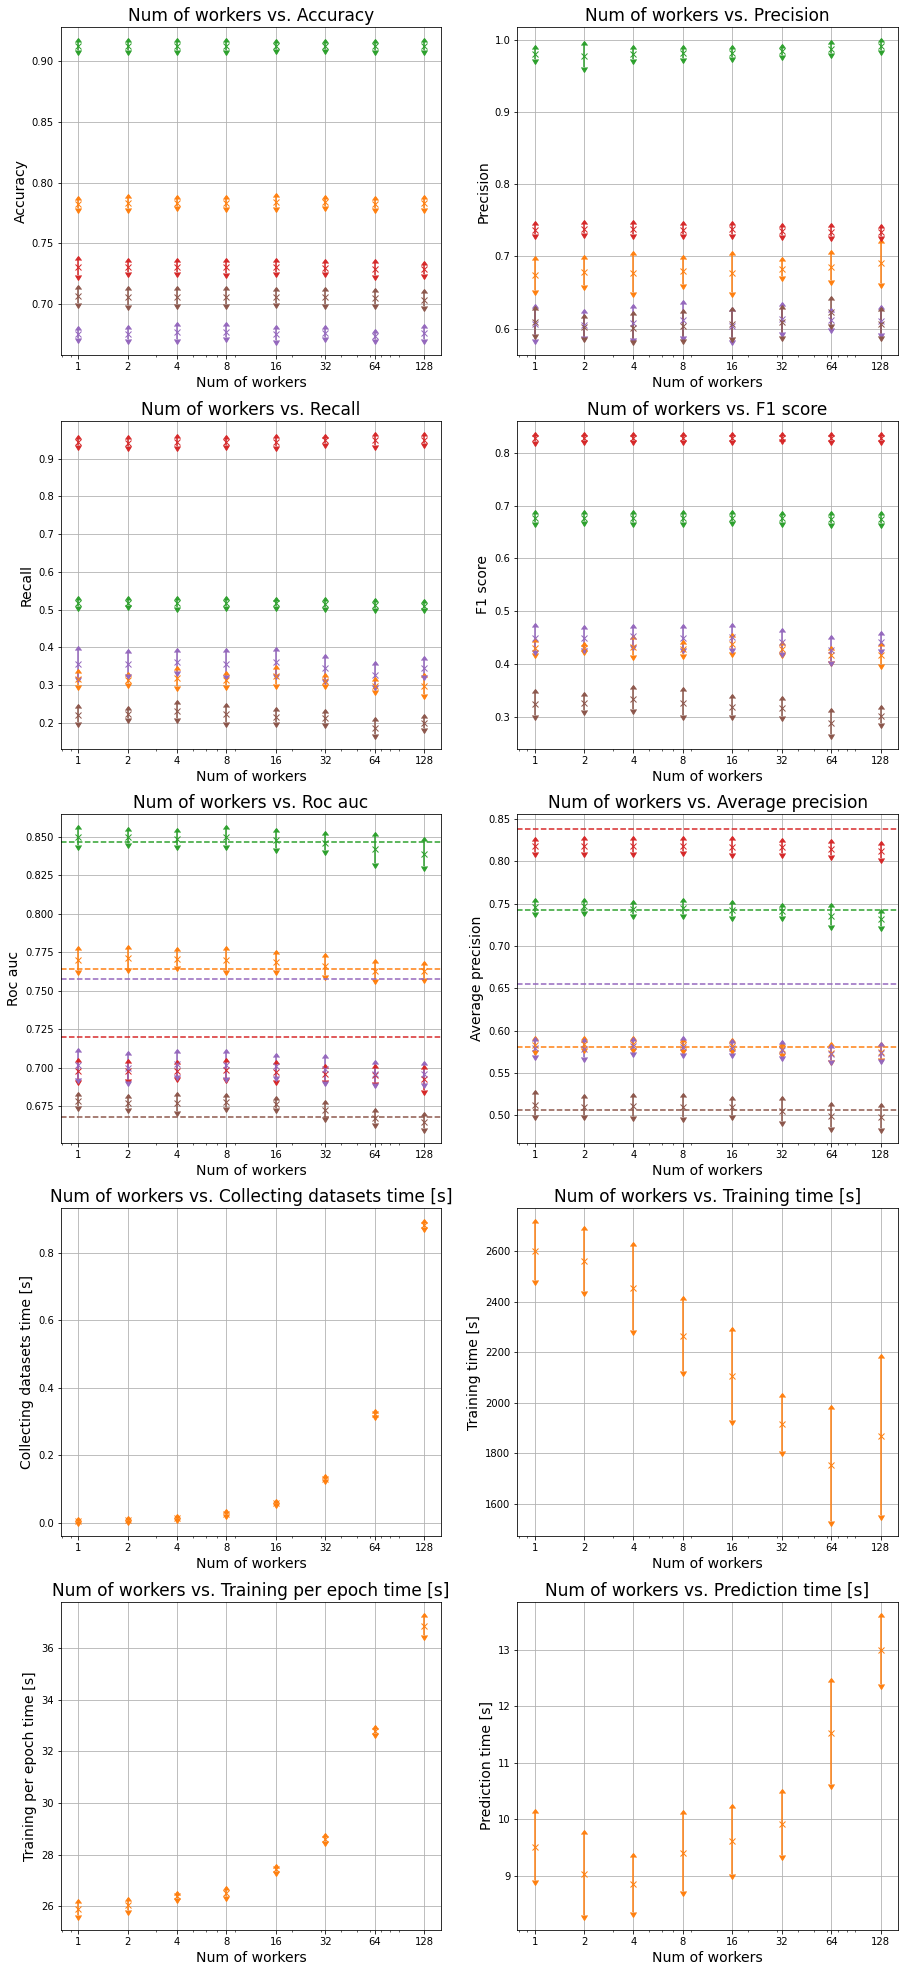

In [16]:
plot(grouped_icd9_workers, 'Num of workers', ICD9_TASKS)